In [ ]:
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from pathlib import Path
import matplotlib.style
import matplotlib as mpl
import torch

import shap

DEVICE = torch.device("cpu")
SEED = 76436278

torch.manual_seed(SEED)
mpl.style.use("default")

checkpoint = torch.load('./model.pt')

site = ["DRIAMS-B"]

fig_path = Path(f"./figures/{site[0]}")
fig_path.mkdir(parents=True, exist_ok=True)

In [ ]:
from src.maldi2resistance.data.driams import Driams

driams = Driams(
    root_dir="/home/jan/Uni/master/data/Driams",
    sites=site,
    antibiotics= checkpoint["selected_antibiotics"],
    cutoff_value= None,
    cutoff_value_negative= None,
    cutoff_value_positive= None
)

driams.loading_type = "memory"

driams.label_stats

100%|██████████| 2371/2371 [00:00<00:00, 4702.86it/s]


,Amikacin,Amoxicillin-Clavulanic acid,Ampicillin-Amoxicillin,Cefazolin,Cefepime,Cefpodoxime,Ceftazidime,Ceftriaxone,Cefuroxime,Ciprofloxacin,...,Meropenem,Nitrofurantoin,Norfloxacin,Oxacillin,Penicillin,Piperacillin-Tazobactam,Rifampicin,Teicoplanin,Tetracycline,Tobramycin
positive,26,536,0,0,269,0,106,115,304,339,...,11,534,143,186,0,188,13,10,130,0
negative,900,1454,0,0,1420,0,834,970,499,1680,...,905,481,657,545,0,987,789,736,747,0
n_sum,926,1990,0,0,1689,0,940,1085,803,2019,...,916,1015,800,731,0,1175,802,746,877,0


In [ ]:
from maldi2resistance.model.MLP import AeBasedMLP

model = AeBasedMLP(input_dim=18000, output_dim=len(driams.selected_antibiotics))
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()

AeBasedMLP(
  (encoder): Encoder(
    (input): Linear(in_features=18000, out_features=4096, bias=True)
    (layer_1): Linear(in_features=4096, out_features=4096, bias=True)
    (layer_2): Linear(in_features=4096, out_features=2048, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
  (decoder): Decoder(
    (input): Linear(in_features=2048, out_features=4096, bias=True)
    (layer_1): Linear(in_features=4096, out_features=4096, bias=True)
    (layer_2): Linear(in_features=4096, out_features=30, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
)

In [ ]:
from torch.utils.data import DataLoader

test_size = len(driams)
test_loader = DataLoader(driams, batch_size= test_size, shuffle=True)
test_features, test_labels = next(iter(test_loader))

In [ ]:
model = model.to(DEVICE)

test_features = test_features.to(DEVICE)
test_labels = test_labels.to(DEVICE)

In [ ]:
from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

In [ ]:
ig = IntegratedGradients(model)
pos = driams.selected_antibiotics.index("Ertapenem")

In [ ]:
attr, delta = ig.attribute(test_features, target= pos, return_convergence_delta= True)
attr = attr.detach().cpu().numpy()

In [ ]:
import matplotlib.pyplot as plt

plt.bar(np.arange(len(attr[0])),np.mean(attr,axis=0))
fig_name = f"IntegratedGradientsBeforeFinetuning@90.png"
plt.savefig(fig_path / fig_name , transparent=True, format= "png", bbox_inches = "tight")
plt.show()
plt.close()

In [ ]:
checkpoint = torch.load('./modelWith90@SiteB.pt')
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()

AeBasedMLP(
  (encoder): Encoder(
    (input): Linear(in_features=18000, out_features=4096, bias=True)
    (layer_1): Linear(in_features=4096, out_features=4096, bias=True)
    (layer_2): Linear(in_features=4096, out_features=2048, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
  (decoder): Decoder(
    (input): Linear(in_features=2048, out_features=4096, bias=True)
    (layer_1): Linear(in_features=4096, out_features=4096, bias=True)
    (layer_2): Linear(in_features=4096, out_features=30, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
)

In [ ]:
attr, delta = ig.attribute(test_features, target= pos, return_convergence_delta= True)
attr = attr.detach().cpu().numpy()

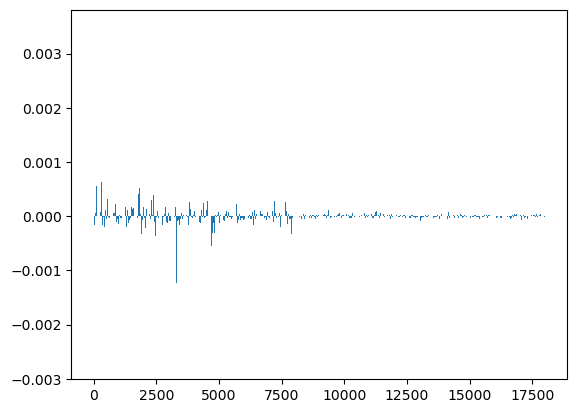

In [ ]:
import matplotlib.pyplot as plt

plot = plt.bar(np.arange(len(attr[0])),np.mean(attr,axis=0))
fig_name = f"IntegratedGradientsAfterFinetuning@90.png"
plt.savefig(fig_path / fig_name , format= "png", bbox_inches = "tight")
plt.show()
plt.close()

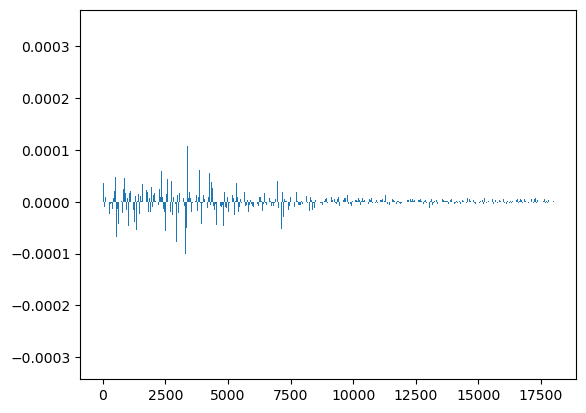

In [ ]:
checkpoint = torch.load('./modelTrainedOnlyOnB.pt')
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()

attr, delta = ig.attribute(test_features, target= pos, return_convergence_delta= True)
attr = attr.detach().cpu().numpy()

plot = plt.bar(np.arange(len(attr[0])),np.mean(attr,axis=0))
fig_name = f"IntegratedGradientsTrainedOnlyOnB.png"
plt.savefig(fig_path / fig_name , format= "png", bbox_inches = "tight")
plt.show()
plt.close()